In the following notebook a CycleGAN architecture is implemented to 'dehaze' underwater images. 

A cycleGAN is a type of GAN used with unpaired datasets (in this case those where basically you do not know the ground truth output) in which two generators $G$ and $F$ are trained with the objective of one being the inverse of the other, that is 

$$G: X \rightarrow Y $$
$$F: Y \rightarrow X $$

where $X$ is the hazed images space and $Y$ is the dehazed images space

Each generator has its own discriminator $D_X$ and $D_Y$ which are trained to determine if an image is real or generated by the respective generator. 

<br>

The following notebook is heavily based on the paper: https://arxiv.org/pdf/1805.05308v1.pdf

We use a underwater dataset that has reference images (the dehazed image version), which are used as the codomain space, not as the ground truth, so we build the dataset pipeline in a way that an input image is not paired with its reference image to force the network to learn the features in the codomain space and not the translation from a hazed image to its dehazed version directly. 

# **Copy Data From Drive**

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
# needed libraries
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dropout, BatchNormalization, Activation, LeakyReLU

# VGG16
from keras.applications.vgg16 import VGG16

# utilities
import os
from glob import glob
import matplotlib.pyplot as plt
import pathlib
import time
import datetime

from IPython import display
from tqdm.auto import tqdm

from google_drive_downloader import GoogleDriveDownloader as gdd

gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Download and Read Data

In [ ]:
gdd.download_file_from_google_drive(file_id   = '1RnZ0OZ1UQlzQb6ibbmvZ6LsJe2PVhxjh',
                                    dest_path = 'data/set_a/raw890.rar')

gdd.download_file_from_google_drive(file_id   = '1cA-8CzajnVEL4feBRKdBxjEe6hwql6Z7',
                                    dest_path = 'data/set_a/reference890.rar')

gdd.download_file_from_google_drive(file_id   = '1Ew_r83nXzVk0hlkfuomWqsAIxuq6kaN4',
                                    dest_path = 'data/set_b/challenging890.rar')

In [ ]:
!mkdir data/train/raw -p
!unrar x -p1234567 data/set_a/raw890.rar data/set_a/
!unrar x -p8901234 data/set_a/reference890.rar data/set_a/
!unrar x -p5678901 data/set_b/challenging890.rar data/set_b/

Define the dataset path and input dimension

In [ ]:
DATA_FOLDER = 'data/set_a/raw-890'
INPUT_DIM     = (256,256,3)

In [ ]:
filenames  = np.array(glob(os.path.join(DATA_FOLDER, '*.png')))
n_images        = filenames.shape[0]

train_size = int(0.8 * n_images)
test_size = n_images - train_size 

print('num image files : ', n_images)
print('train size : ', train_size)
print('test size : ', test_size)
print('total: ', train_size + test_size)

num image files :  890
train size :  712
test size :  178
total:  890


# Utilities to Preprocess Dataset

We define utility functions to read the images. Each input of the network has the following form 

<br> 
$$(Input \; Image, \; Unpaired \; Image, \; Reference \; Image)$$

<br>

<div style="text-align: justify"> where $Input \; Image$ is an image from the 'hazed' underwater dataset, $Unpaired \; Image$ is an image from the 'dehazed' underwater dataset (codomain) and $Reference \; Image$ is a high quality dehazed imagen version of the $Input \; Image$. </div>

<br>

<div style="text-align: justify"> We also use a data augmentation process in which we take random crops of random sizes from the images and then resize them to the $256 \times 256$ input size of the network, very similar to the process described in the reference paper mentioned above. The idea of the data augmentation process is to make the model learn different scales of representation of the data. </div>



In [ ]:
import numpy as np
import cv2

# normalize an image  
def normalize(img):
  img = (img / 127.5) - 1
  return img

def dataAugmentation(img, n_crops=2):
  height, width, channels = img.shape
  crop_list = []

  for _ in range(n_crops):
    x, y = np.random.randint(0, 256-32, 2)
    rand_height, rand_width = 256, 256

    while rand_height + x >= 256 and rand_width + y >= 256: 
      rand_height, rand_width = np.random.randint(32, 160, 2)

    crop = img[y:y + rand_height, x:x + rand_width, :]
    crop = tf.image.resize(crop, (256, 256))
    crop = tf.expand_dims(crop, axis=0)
    crop_list.append(crop)

  return crop_list

# function to load the dataset, it receives an image path and returns the original image
# and the scracthed image 

def getUnpairedImages(raw_image_path, ref_image_path, u_image_path):

  #if flag == 1:
  #  ref_image_path = u_image_path

  # Read, decode and resize an image file to a uint8 tensor
  raw_image = tf.io.read_file(raw_image_path)
  raw_image = tf.image.decode_png(raw_image)
  raw_image = tf.image.resize(raw_image, (256, 256))

  ref_image = tf.io.read_file(ref_image_path)
  ref_image = tf.image.decode_png(ref_image)
  ref_image = tf.image.resize(ref_image, (256, 256))

  u_image = tf.io.read_file(u_image_path)
  u_image = tf.image.decode_png(u_image)
  u_image = tf.image.resize(u_image, (256, 256))

  # Convert both images to float32 tensors
  raw_image = tf.cast(tf.identity(raw_image), tf.float32)
  ref_image = tf.cast(tf.identity(ref_image), tf.float32)
  u_image = tf.cast(tf.identity(u_image), tf.float32)

  raw_image = normalize(raw_image)
  ref_image = normalize(ref_image)
  u_image = normalize(u_image)

  return [tf.expand_dims(raw_image, axis=0), tf.expand_dims(ref_image, axis=0), tf.expand_dims(u_image, axis=0)]

def getChallengeImg(raw_image_path):
  raw_image = tf.io.read_file(raw_image_path)
  raw_image = tf.image.decode_png(raw_image)
  raw_image = tf.image.resize(raw_image, (256, 256))

  # Convert both images to float32 tensors
  raw_image = tf.cast(tf.identity(raw_image), tf.float32)

  raw_image = normalize(raw_image)
  
  return tf.expand_dims(raw_image, axis=0)

In [ ]:
def deNormalize(img):
  img = (img + 1)* 0.5
  return img

def getRange(img):
  return np.min(img), np.max(img)

# Build Dataset

A continuación tenemos el flujo de los datos para obtener cada uno de nuestros elementos del dataset. Inicialmente obtenemos los nombres de las imagenes y luego estos pasan a una función que se encarga de leer el archivo, reescalar la imagen y obtener una imagen con rayones aleatorios.

Next we have the input pipeline of the data. Data filenames from the 'hazed' dataset are retrieved and paired with their high resolution 'dehazed' image and then this zipped dataset is zipped with an unpaired image of the 'dehazed' dataset.

In [ ]:
RAW_DATA_FOLDER   = 'data/set_a/raw-890/'
REF_DATA_FOLDER   = 'data/set_a/reference-890/'

# get paths in dataset
RAW_PATH  = pathlib.Path(RAW_DATA_FOLDER)
REF_PATH  = pathlib.Path(REF_DATA_FOLDER)
raw_dataset = tf.data.Dataset.list_files(str(RAW_PATH / '*.png'), shuffle=False)
ref_dataset = tf.data.Dataset.list_files(str(REF_PATH / '*.png'), shuffle=False)
unpair_dataset = tf.data.Dataset.list_files(str(REF_PATH / '*.png'), shuffle=True)

dataset = tf.data.Dataset.zip((raw_dataset, ref_dataset, unpair_dataset))
dataset = dataset.shuffle(100)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# get train and test dataset
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

# add layer to read original and scratched image
train_ds = train_ds.map(lambda x, y, z: tf.numpy_function(func=getUnpairedImages, inp=[x, y, z], Tout=((tf.float32, tf.float32, tf.float32))), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y, z: tf.numpy_function(func=getUnpairedImages, inp=[x, y, z], Tout=(tf.float32, tf.float32, tf.float32)), num_parallel_calls=AUTOTUNE)

In [ ]:
RAW_DATA_FOLDER   = 'data/set_b/challenging-60/'

# get paths in dataset
RAW_PATH  = pathlib.Path(RAW_DATA_FOLDER)
chall_raw_dataset = tf.data.Dataset.list_files(str(RAW_PATH / '*.png'), shuffle=False)

AUTOTUNE = tf.data.AUTOTUNE

# add layer to read original and scratched image
chall_test_ds = chall_raw_dataset.map(lambda x: tf.numpy_function(func=getChallengeImg, inp=[x], Tout=(tf.float32)), num_parallel_calls=AUTOTUNE)

<h2> Visualize Images From Dataset </h2>

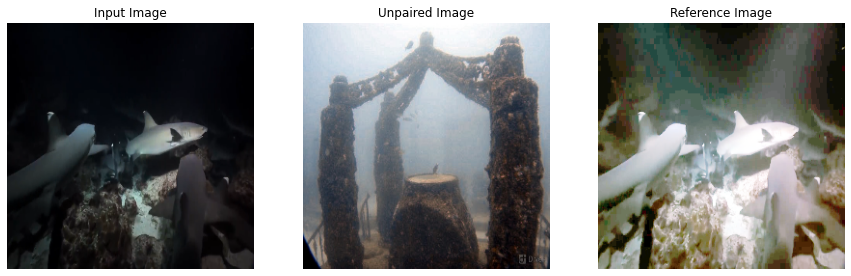

In [ ]:
# try dataset
datatmp = train_ds.take(1)
data = list(datatmp)
inp, tar = data[0][0], data[0][1]

plt.figure(figsize=(15, 15))
display_list = [data[0][0], data[0][2], data[0][1]]
title = ['Input Image', 'Unpaired Image', 'Reference Image']

for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.title(title[i])
  # Getting the pixel values in the [0, 1] range to plot.
  plt.imshow(display_list[i][0]* 0.5 + 0.5)
  plt.axis('off')
plt.show()

<h2> Visualize Crops </h2>

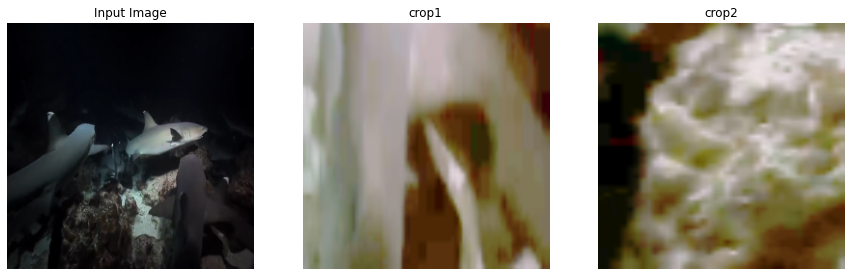

In [ ]:
inp_crops = dataAugmentation(tar[0], 2)
plt.figure(figsize=(15, 15))
display_list = [inp[0], inp_crops[0][0], inp_crops[1][0]]
title = ['Input Image', 'crop1', 'crop2']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]* 0.5 + 0.5)
    plt.axis('off')
plt.show()

# Network Architecture

In [ ]:
OUTPUT_CHANNELS = 3

<h2> Encoder </h2>

The encoder is based on a convolutional layer follow from a  Batch Normalization and finally a LeakyReLU as activation. The encoder layer can also use an ReLU as activation.

In [ ]:
def downsample(filters, size, apply_batchnorm=True, strides=2, padding='same', activation='LeakyReLU'):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding,
                             use_bias=True))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  if activation == 'ReLU':
    result.add(tf.keras.layers.ReLU())
  elif activation == 'LeakyReLU':
    result.add(tf.keras.layers.LeakyReLU())

  return result

<h2> Decoder </h2>

The decoder in the other hand is made by a transposed convolution (known as deconvolution) followed by a Batch Normalization layer and finally a ReLU activation.

In [ ]:
def upsample(filters, size, strides=2, padding='same', use_activation=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                    padding=padding,
                                    use_bias=True))

  result.add(tf.keras.layers.BatchNormalization())
  
  if use_activation:
    result.add(tf.keras.layers.ReLU())

  return result

Residual blocks basically consist of two encoder layers one following the other where the first one uses a ReLU activation and the second has no activation function, i.e identity activation.  

In [ ]:
def resisudal_block(filters, size):
  result = tf.keras.Sequential()
  result.add(downsample(filters, size, strides=1, activation='ReLU'))
  result.add(downsample(filters, size, strides=1, activation='None'))

  return result

<h2> Generator </h2>

El generador consiste básicamente en varias capas para encodificar los datos y hacer una reducción de dimensiones y luego proceder de manera inversa con varias capas de decodificadores. Cada capa de encoder se encuentra conectada a una capa del decodificador al estilo de una red residual.

The Generator of the cycleGAN consist of several stacked encoder layers follow by 6 residual blocks and finally several stacked decoder layers. As activation function of the Generator a  $tanh(x)$ function is used to retrieve values from $[-1, 1]$ and then this values are scaled to the [0, 1] values admitted by images.

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(32, 7, strides=1, activation='ReLU'),   # (batch_size, 256, 256, 32)
    downsample(64, 3, activation='ReLU'),              # (batch_size, 128, 128, 64)
    downsample(128, 3, activation='ReLU'),             # (batch_size, 64, 64, 128)
  ]

  res_blocks = [
    resisudal_block(128, 3),        # (batch_size, 64, 64, 128)
    resisudal_block(128, 3),        # (batch_size, 64, 64, 128)
    resisudal_block(128, 3),        # (batch_size, 64, 64, 128)
    resisudal_block(128, 3),        # (batch_size, 64, 64, 128)
    resisudal_block(128, 3),        # (batch_size, 64, 64, 128)
    resisudal_block(128, 3)         # (batch_size, 64, 64, 128)
  ]

  up_stack = [
    upsample(64, 3, strides=2, padding='same'),        # (batch_size, 128, 128, 64)
    upsample(32, 3, strides=2, padding='same'),        # (batch_size, 256, 256, 32)
    downsample(3, 7, strides=1, activation='None'),    # (batch_size, 256, 256, 3)
  ]

  last = tf.keras.layers.Activation(tf.keras.activations.tanh)
  x = inputs

  # Downsampling through the model
  for down in down_stack:
    x = down(x)
  
  # residual blocks
  for res_block in res_blocks:
    x = keras.layers.Add()([x, res_block(x)])

  # Upsampling and establishing the skip connections
  for up in up_stack:
    x = up(x)

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

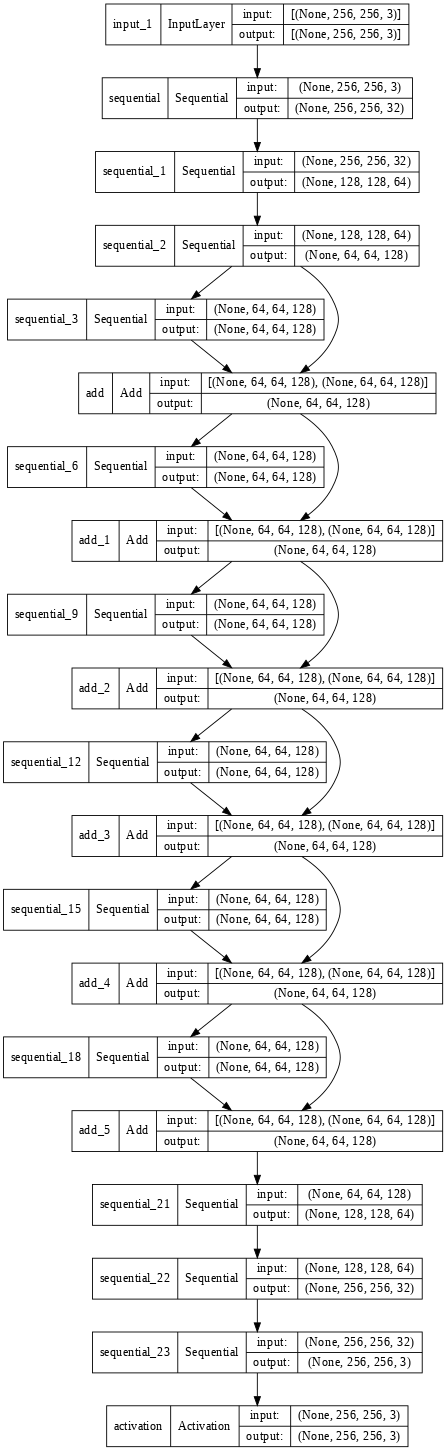

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

(-1.0, 1.0)


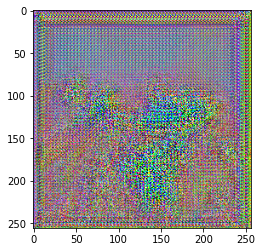

In [ ]:
gen_output = generator(inp, training=True)
print(getRange(gen_output))
img_out = deNormalize(gen_output[0])
plt.imshow(img_out)

<h2> Loss Object used by the Generator</h2>

In [ ]:
#loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_object = tf.keras.losses.MeanSquaredError()
l1_loss = keras.losses.MeanAbsoluteError()

In [ ]:
def generator_loss(disc_generated_output):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  return gan_loss

<h2> Discriminator </h2>

as a discriminator a PatchGAN that takes $70 \times 70$ overlapping patches of time image is used.

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  
  down1 = downsample(64, 4, False)(inp)   # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)       # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)       # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=True)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp], outputs=last)

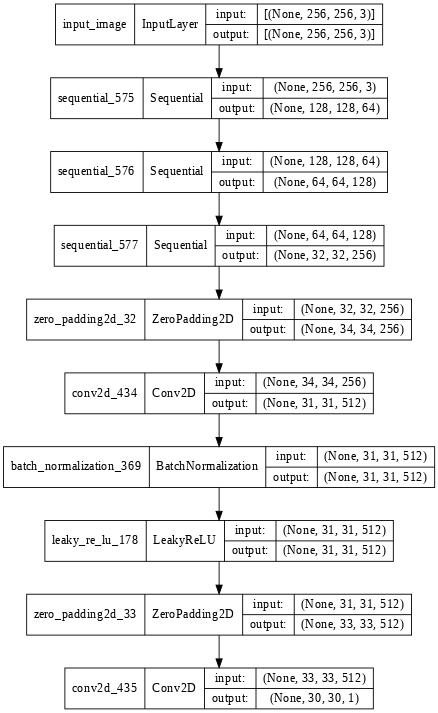

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

(-5.9756565, 7.066409)


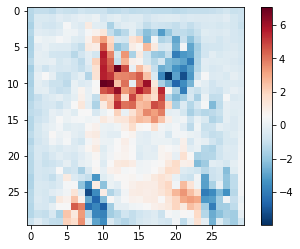

In [ ]:
disc_out = discriminator([inp], training=True)
print(getRange(disc_out))
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.colorbar()

<h2> Define Discriminator Loss</h2>

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

# CycleGAN Loss functions

<h2> Cycle Consistency Loss </h2>

As described in the paper, there are extra loss functions used by a CycleGAN, one of them is the cycle consistency loss which aims to push the generators of the cycleGAN to be able to retrieve the original image once it is passed by both generators, i.e 

$$G(F(x)) = x $$

where $F$ and $G$ are the generators that map from the 'hazed' space to the 'dehazed' space and viceversa.   

In [ ]:
def cycle_loss(F_G_x, G_F_y, x, y):
  loss_x = l1_loss(F_G_x, x)
  loss_y = l1_loss(G_F_y, y)

  return loss_x + loss_y


# VGG16 Features Extractor

Aditionally to the Cycle Consistency Loss, a feature loss named perceptual loss is also calculated to enhance the similarity of the output image with the 'dehazed' space in a features space. Therefore, the VGG16 $2nd$ and $5th$ pooling layers are used with this purpose.

In [ ]:
vgg16 = VGG16()

553476096/553467096 [==============================] - 6s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def getFeaturesExtractor():
  input = keras.layers.Input([256, 256, 3])

  x = keras.layers.Resizing(
    224, 224, interpolation="bilinear", crop_to_aspect_ratio=False, name='resize')(input)

  for layer in vgg16.layers:
    layer.trainable = False
  
  for layer in vgg16.layers[1:]:
    x = layer(x)

    if layer.name == 'block2_pool':
      print('getting pool in block2')
      block2 = x
    
    if layer.name == 'block5_pool':
      print('getting pool in block5')
      block5 = x
      break
  
  FB2 = keras.Model(inputs=input, outputs=block2)
  FB5 = keras.Model(inputs=input, outputs=block5)

  return FB2, FB5

# Perceptual Loss

In [ ]:
def get_perceptual_loss(feat_real_img, feat_decoded_img):
  return loss_object(feat_real_img, feat_decoded_img) 

# Build Model

In [ ]:
genG = Generator()
genF = Generator()
discX = Discriminator()
discY = Discriminator()
FeatBlock2, FeatBlock5 = getFeaturesExtractor()

getting pool in block2
getting pool in block5


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
final_file = '/content/drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea4/weights_no_init_augmentation_FeatBlockCorrected'

final_checkpoint = tf.train.Checkpoint(genG=genG,
                                       genF=genF,
                                       discX=discX,
                                       discY=discY)


# Load Model If necessary

In [ ]:
final_checkpoint.read(final_file).assert_consumed()

# Generate Images

For image generation the trained $G$ generator is applied to 'hazed' underwater images to obtain 'dehazed' underwater images. To obtain high resolution images the laplacian pyramid upscaling process is used. The gaussian pyramid is constructed for both the output of generator $G$ image and the original image. Then Laplacian pyramid is constructed for the original (haze underwater) image and before doing the Laplacian upscailing, the top level of the built Laplacian pyramid is modified with the top level of the dehazed gaussian pyramid (the gaussian pyramid constructed for the output of generator $G$) and after that the Laplacian upscailing process is done as regular. 

In [ ]:
def get_gaussian_pyramid(img):
  gauss_pyramid = [img]
  height, width, channels = img.shape

  while height > 8:
    height //= 2
    width //= 2
    img = cv2.pyrDown(img, dstsize=(height, width))
    gauss_pyramid.append(img)
  
  return gauss_pyramid


In [ ]:
def LaplacianUpscaling(dehaze_image, hr_hazed_image, wg_Ik=1.0, wg_gauss=0.0):
  deh_gauss_pyr = get_gaussian_pyramid(dehaze_image)
  hr_srcImg_pyr = get_gaussian_pyramid(hr_hazed_image)
  laplacian_pyr = []

  # compute laplacian pyramid
  for i in range(len(hr_srcImg_pyr) - 1):
    height, width, channels = hr_srcImg_pyr[i].shape
    laplacian_pyr.append(hr_srcImg_pyr[i] - cv2.pyrUp(hr_srcImg_pyr[i+1], dstsize=(height, width)))
  
  Ik = deh_gauss_pyr[-1]
  
  height_dest, width_dest, channels_dest = Ik.shape
  
  # upscale image
  while height_dest < 256:
    height_dest *= 2
    width_dest *= 2
    Ik = cv2.pyrUp(wg_Ik * Ik + wg_gauss * deh_gauss_pyr[-1], dstsize=(height_dest, width_dest)) + laplacian_pyr[-1]
    laplacian_pyr.pop(-1)
    deh_gauss_pyr.pop(-1)
  
  return Ik


In [ ]:
def generate_images(model, test_input, tar, lap_up=True, wg_Ik=1.0, wg_gauss=0.0):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  
  hr_img = LaplacianUpscaling(prediction[0].numpy(), test_input[0].numpy(), wg_Ik, wg_gauss) if lap_up else prediction[0]

  display_list = [test_input[0], hr_img, tar[0]]
  title = ['Input Image', 'Predicted Image', 'Reference Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]* 0.5 + 0.5)
    plt.axis('off')
  plt.show()

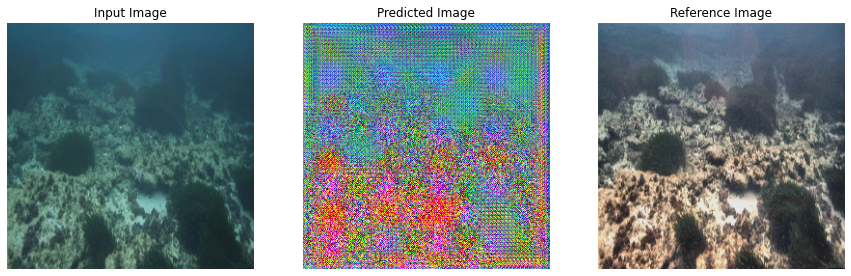

In [ ]:
for example_input, example_target, _ in test_ds.take(1):
  generate_images(genG, example_input, example_target, lap_up=False)

# Train

we train the network by two steps, in the even epochs we train the Discriminators and in the odd epochs we train the Generators.

In [ ]:
log_dir="/content/drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea4/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
LAMBDA = 0.0001

In [ ]:
@tf.function
def generator_train_step(input_image, u_image, step):
  with tf.GradientTape() as genG_tape, tf.GradientTape() as genF_tape:

    # used for both optimization rounds
    G_x = genG(input_image, training=True)
    F_y = genF(u_image, training=True)

    D_F_y = discX(F_y, training=True)
    D_G_x = discY(G_x, training=True)

    F_G_x = genF(G_x, training=True)
    G_F_y = genG(F_y, training=True)
    # cycle loss
    cyc_loss = cycle_loss(F_G_x, G_F_y, input_image, u_image)
    # perceptual loss
    perc_loss = get_perceptual_loss(FeatBlock2(input_image*0.5*255 +0.5*255), FeatBlock2(F_G_x*0.5*255 +0.5*255)) \
                + get_perceptual_loss(FeatBlock5(input_image*0.5*255 +0.5*255), FeatBlock5(F_G_x*0.5*255 +0.5*255))\
                + get_perceptual_loss(FeatBlock2(u_image*0.5*255 +0.5*255), FeatBlock2(G_F_y*0.5*255 +0.5*255))\
                + get_perceptual_loss(FeatBlock5(u_image*0.5*255 +0.5*255), FeatBlock5(G_F_y*0.5*255 +0.5*255)) 
    # generator loss
    genG_loss = generator_loss(D_G_x)
    genF_loss = generator_loss(D_F_y)

    genG_total_loss = genG_loss + 10 * cyc_loss + LAMBDA * perc_loss
    genF_total_loss = genF_loss + 10 * cyc_loss + LAMBDA * perc_loss

  genG_grads = genG_tape.gradient(genG_total_loss, genG.trainable_variables)
  genF_grads = genF_tape.gradient(genF_total_loss, genF.trainable_variables)
  
  generator_optimizer.apply_gradients(zip(genG_grads, genG.trainable_variables))
  generator_optimizer.apply_gradients(zip(genF_grads, genF.trainable_variables))
  
  return genG_total_loss, genF_total_loss

In [ ]:
@tf.function
def disc_train_step(input_image, u_image, step):
  with tf.GradientTape() as discX_tape, tf.GradientTape() as discY_tape:

    # used for both optimization rounds
    G_x = genG(input_image, training=True)
    F_y = genF(u_image, training=True)

    D_F_y = discX(F_y, training=True)
    D_G_x = discY(G_x, training=True)

    D_x = discX(input_image, training=True)
    D_y = discY(u_image, training=True)
    # discriminator loss
    discX_loss = discriminator_loss(D_x, D_F_y)
    discY_loss = discriminator_loss(D_y, D_G_x)

  discX_grads = discX_tape.gradient(discX_loss, discX.trainable_variables)
  discY_grads = discY_tape.gradient(discY_loss, discY.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(discX_grads, discX.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discY_grads, discY.trainable_variables))

  return discX_loss, discY_loss

# Train with data Augmentation

In [ ]:
def fit(train_ds, test_ds, epochs, initial_epoch=0):
  example_input, example_target, _ = next(iter(test_ds.take(1)))

  for epoch in range(initial_epoch, initial_epoch + epochs):
    print('Epoch: ', epoch)
    
    turn = epoch % 2
    genG_losses = []
    genF_losses = []
    discX_losses = []
    discY_losses = []

    if turn == 0:
      generate_images(genG, example_input, example_target)
    
    for step, (input_image, _, u_image) in tqdm(train_ds.enumerate()):
      inputs = dataAugmentation(input_image[0], n_crops=2)
      targetSpace = dataAugmentation(u_image[0], n_crops=2)
      inputs.append(input_image)
      targetSpace.append(u_image)

      for (input_image, u_image) in zip(inputs, targetSpace):

        if turn == 1:
          genG_loss, genF_loss = generator_train_step(input_image, u_image, step)
          genG_losses.append(genG_loss)
          genF_losses.append(genF_loss)
        else:
          discX_loss, discY_loss = disc_train_step(input_image, u_image, step)
          discX_losses.append(discX_loss)
          discY_losses.append(discY_loss)

    if turn == 1:
      print('genG losses:', genG_losses)
      print('genF losses:', genF_losses)
      genG_mean_loss = tf.math.reduce_mean(genG_losses)
      genF_mean_loss = tf.math.reduce_mean(genF_losses)
      print('genG_mean_loss: {:.6f}, genF_mean_loss: {:.6f}'.format(genG_mean_loss, genF_mean_loss))
    else:
      print('discX losses:', discX_losses)
      print('discY losses:', discY_losses)
      discX_mean_loss = tf.math.reduce_mean(discX_losses)
      discY_mean_loss = tf.math.reduce_mean(discY_losses)
      print('discX_mean_loss: {:.6f}, discY_mean_loss: {:.6f}'.format(discX_mean_loss, discY_mean_loss))

    final_checkpoint.write(final_file)

In [ ]:
fit(train_ds, test_ds, epochs=10, initial_epoch=0)

# Testing the generator

In the following lines we can see the results obtained with the generator trained by 60 epochs. With the shark image under the light we can see a real improvement between the reference image and the predicted image. The reference image portraits a very artificial light and the quality is not so good. In the other hand, the predicted image portraits a soft light effect and looks more natural. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


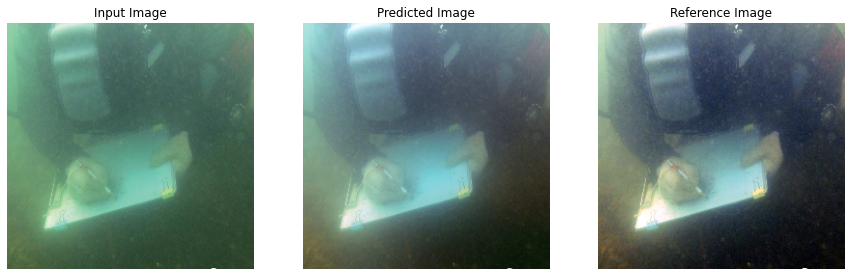

In [ ]:
for example_input, example_target, _ in test_ds.take(1):
  generate_images(genG, example_input, example_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
5


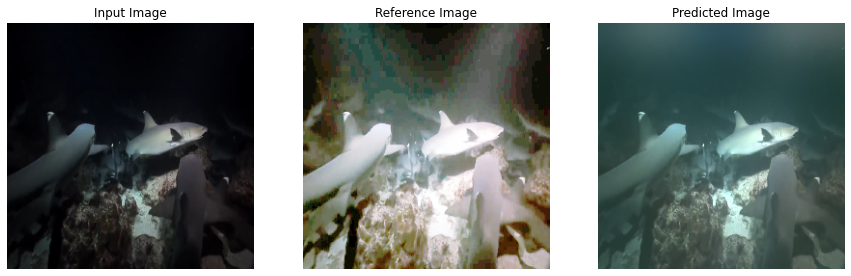

In [ ]:
img, ref, uimg = list(train_ds.take(1))[0]
generate_images(genG, img, ref)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


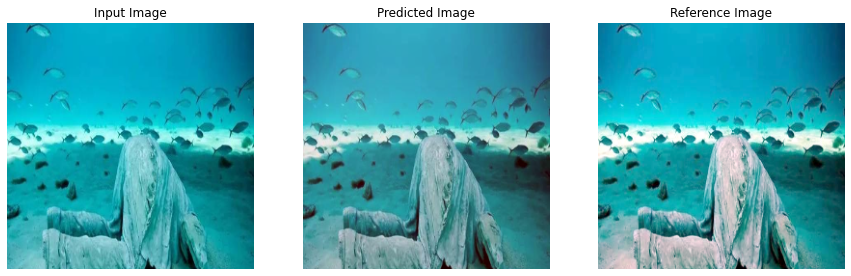

In [ ]:
for example_input, example_target, _ in test_ds.take(1):
  generate_images(genG, example_input, example_target)

In the following examples we can see several results, some of them show really nice and "natural" results, but some others show images that have improven their quality but still do not get the quality of the reference images. This could be due to some reference images sometimes are shaded or look like they have a "filter" on, so this could push the network to learn incorrect features from the codomain space give the fact that the reference images are used as the codomain space.

In [ ]:
img_list = list(test_ds.take(10))

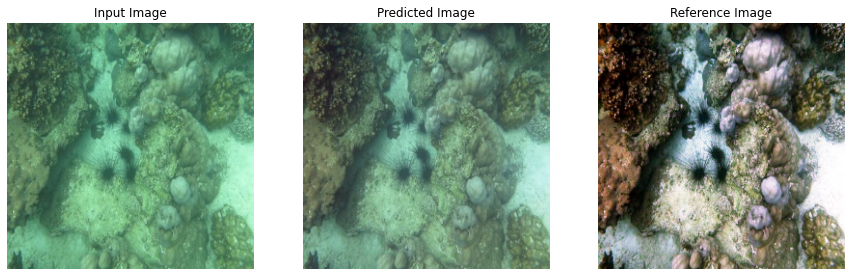

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


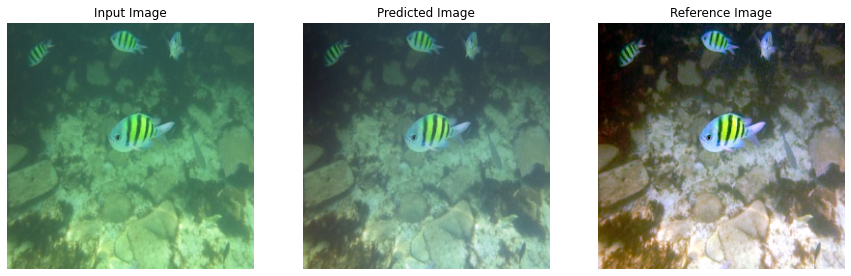

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


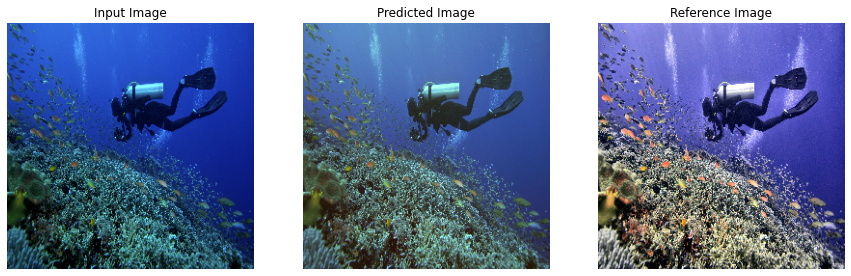

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


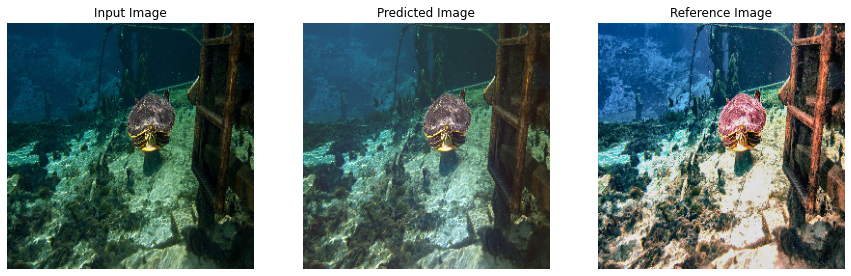

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


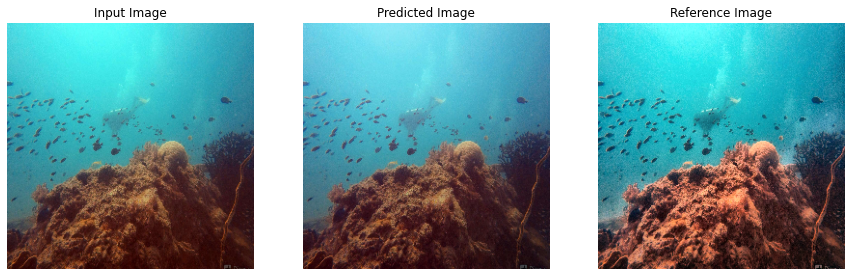

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


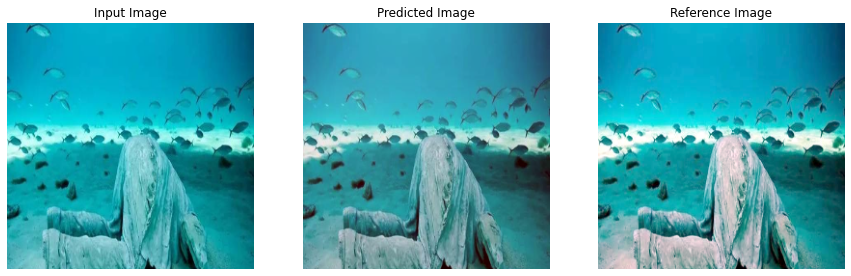

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


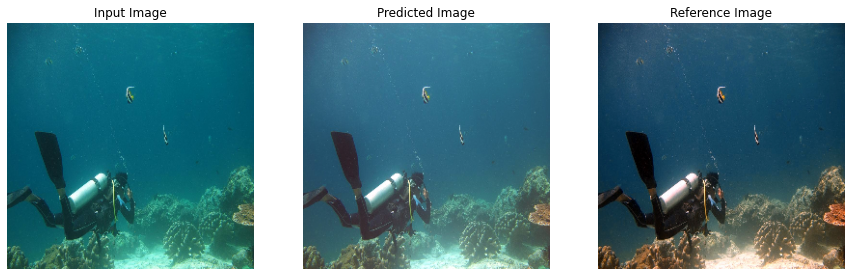

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


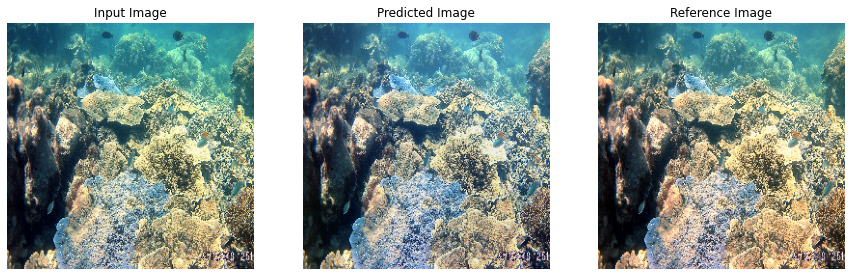

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


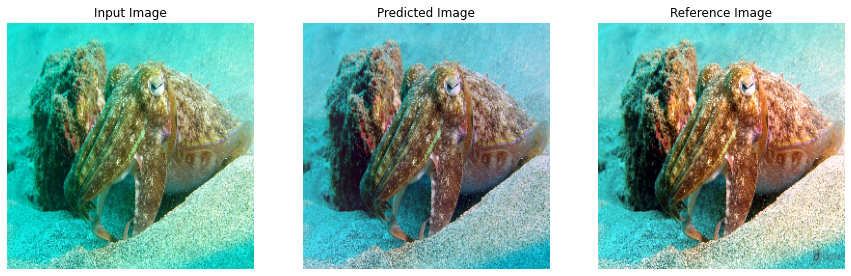

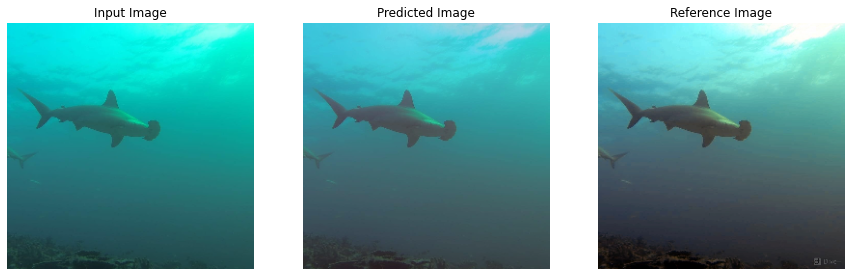

In [ ]:
for img_pair in img_list:
  img, ref, uimg = img_pair
  generate_images(genG, img, ref, lap_up=True)


#Testing with Challenge Dataset

In [ ]:
def generate_chall_images(model, test_input, lap_up=True, wg_Ik=1.0, wg_gauss=0.0):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  
  hr_img = LaplacianUpscaling(prediction[0].numpy(), test_input[0].numpy(), wg_Ik, wg_gauss) if lap_up else prediction[0]

  display_list = [test_input[0], hr_img]
  title = ['Input Image', 'Predicted Image', 'Reference Image']

  for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]* 0.5 + 0.5)
    plt.axis('off')
  plt.show()

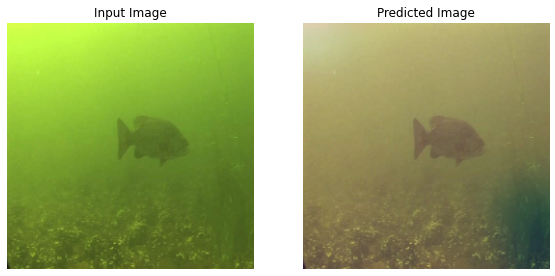

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


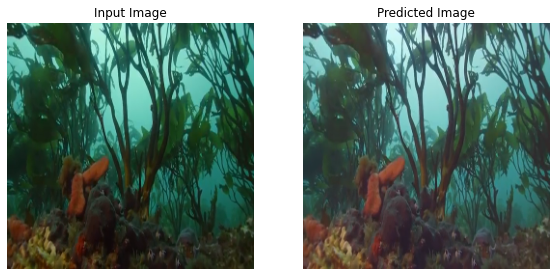

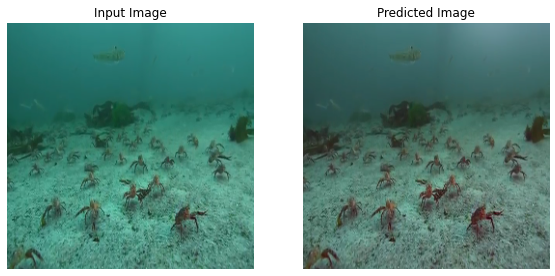

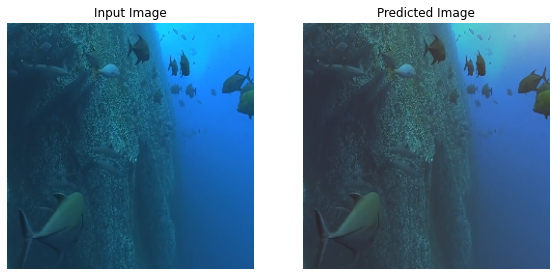

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


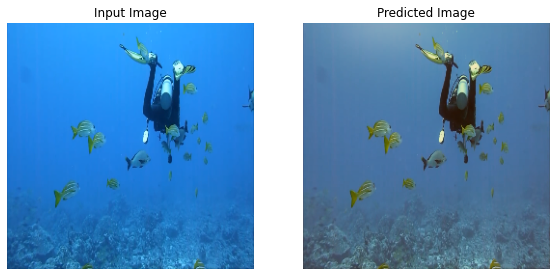

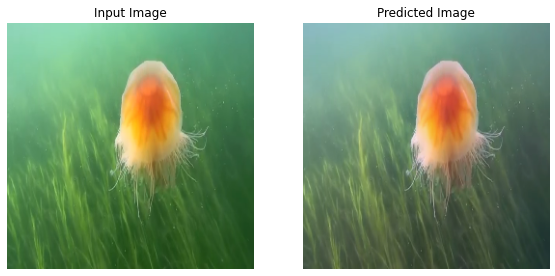

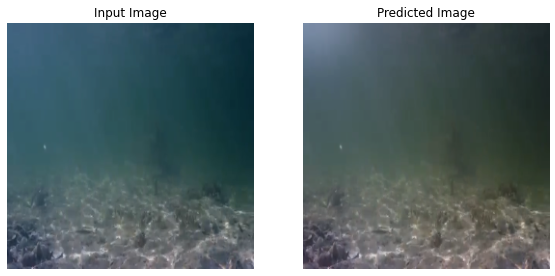

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


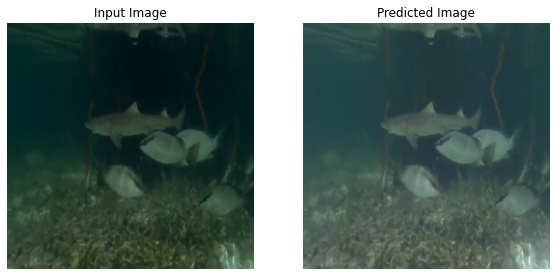

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


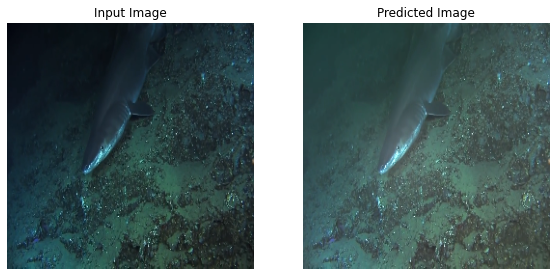

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


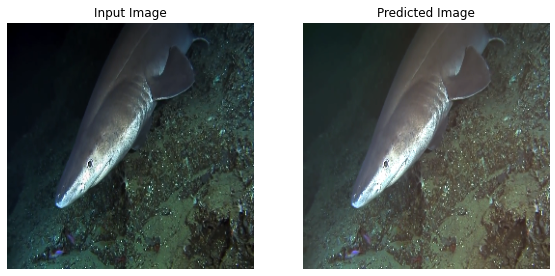

In [ ]:
img_list = list(chall_test_ds.take(10))
for img_pair in img_list:
  img = img_pair
  generate_chall_images(genG, img, lap_up=True)